# Walkthrough - RBIG

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

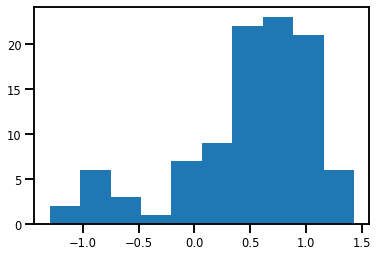

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

## Data

<Figure size 432x288 with 0 Axes>

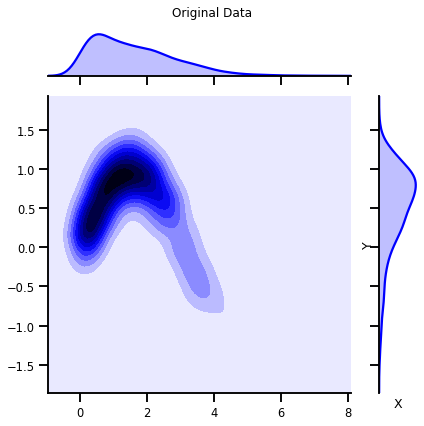

In [3]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

<AxesSubplot:>

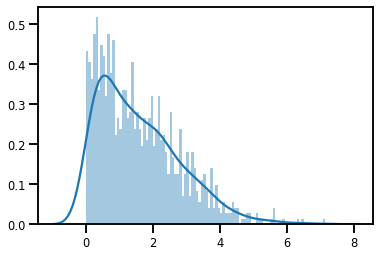

In [4]:
X_marg = data[:, 0]

sns.distplot(X_marg, bins=100)

## State Variables

In [5]:
import collections
TransformState = collections.namedtuple(
    "TransformState", ["X", "ldj", "info_reduction"]
)

## Histogram Uniformization

In [6]:
from rbig_jax.transforms.histogram import (
    get_hist_params
)
# from rbig_jax.transforms.kde import get_kde_params
# from rbig_jax.transforms.uniformize import forward_uniformization, inverse_uniformization, forward_uniformization_gradient

In [7]:
# marginal Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 1_000
nbins = int(np.sqrt(X_marg.shape[0]))

histogram_uniformize = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [8]:
# Transformation
X_u, hist_params = histogram_uniformize(X_marg) 

<AxesSubplot:>

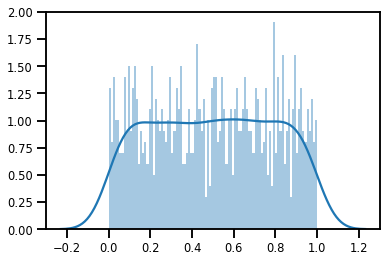

In [9]:
sns.distplot(X_u, bins=100)

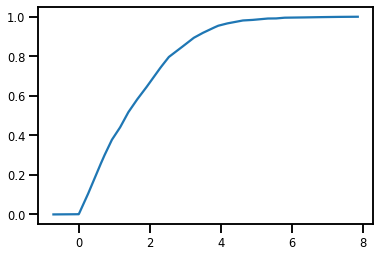

In [10]:
plt.plot(hist_params.support, hist_params.quantiles)

#### JIT

In [11]:
# JIT Compile (OPTIONAL)
histogram_uniformize_jitted = jax.jit(histogram_uniformize)

In [12]:
X_u, hist_params = histogram_uniformize_jitted(X_marg) 
%timeit histogram_uniformize_jitted(np.array(X_marg).block_until_ready())
%timeit histogram_uniformize(np.array(X_marg)) 

285 µs ± 3.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
68.8 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Forward Transformation

In [13]:
from rbig_jax.transforms.uniformize import uniformize_transform, uniformize_inverse, uniformize_gradient

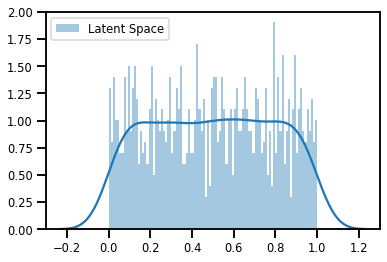

In [14]:
X_u = uniformize_transform(X_marg, hist_params)

sns.distplot(X_u, bins=100, label="Latent Space")
plt.legend()

### Inverse Transformation

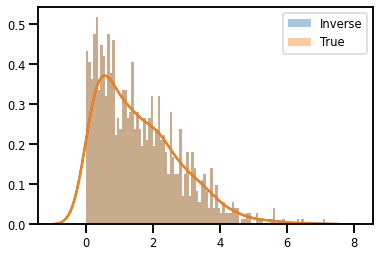

In [15]:
X_approx = uniformize_inverse(X_u, hist_params)


sns.distplot(X_approx, bins=100, label="Inverse")
sns.distplot(X_marg, bins=100, label="True")
plt.legend()

### Jacobian

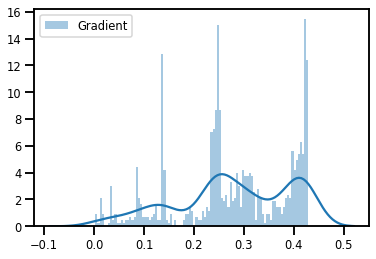

In [16]:
X_grad = uniformize_gradient(X_marg, hist_params)


plt.figure()
sns.distplot(X_grad, bins=100, label="Gradient")
plt.legend()
plt.show()

## Inverse CDF Estimation

In [17]:
from rbig_jax.transforms.inversecdf import invgausscdf_forward_transform, invgausscdf_inverse_transform

### Forward Transform

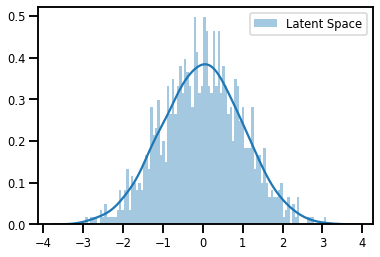

In [18]:
X_g = invgausscdf_forward_transform(X_u)

plt.figure()
sns.distplot(X_g, bins=100, label="Latent Space")
plt.legend()
plt.show()

### Inverse Transform

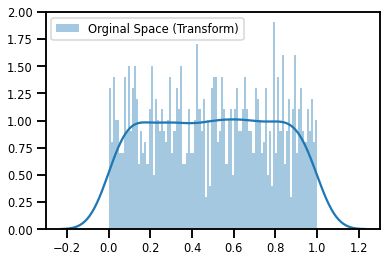

In [19]:
X_u = invgausscdf_inverse_transform(X_g)

plt.figure()
sns.distplot(X_u, bins=100, label="Orginal Space (Transform)")
plt.legend()
plt.show()

## Univariate Gaussianization

In [20]:
from rbig_jax.transforms.gaussianize import (
    gaussianize_forward, 
    gaussianize_inverse, 
    gaussianize_transform,
    get_gauss_params_hist
)

In [21]:
# marginal Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 1_000

# create marginal transformation function (HISTOGRAM)
histogram_uniformize = jax.partial(
    get_hist_params, 
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# JIT Compile (OPTIONAL)
histogram_uniformize = jax.jit(histogram_uniformize)

In [22]:
from typing import Callable

def uni_gaussianize(
    X: np.ndarray, 
    uni_transform_f: Callable):
    
    # forward uniformization function
    X, params = uni_transform_f(X)
    # clip boundaries
    X = np.clip(X, 1e-5, 1.0 - 1e-5)

    # inverse cdf
    X = invgausscdf_forward_transform(X)

    return X, params



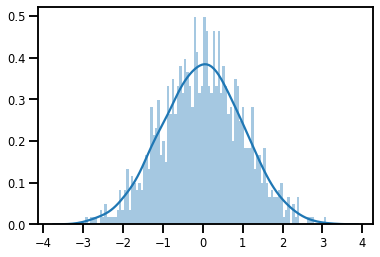

In [23]:
X_g, gauss_params = uni_gaussianize(X_marg, histogram_uniformize_jitted)

plt.figure()
sns.distplot(X_g, bins=100, label="Latent Space")
plt.show()

#### Forward Transformation

In [24]:
UniParams = collections.namedtuple(
    "UniParams", ["support", "quantiles", "support_pdf", "empirical_pdf"]
)

def uniformize_transform(X: np.ndarray, params: UniParams) -> np.ndarray:
    """Forward univariate uniformize transformation
    
    Parameters
    ----------
    X : np.ndarray
        The univariate data to be transformed.
    
    params: UniParams
        the tuple containing the params. 
        See `rbig_jax.transforms.uniformize` for details.
    
    Returns
    -------
    X_trans : np.ndarray
        The transformed univariate parameters
    """
    return np.interp(X, params.support, params.quantiles)


def uni_gaussianize_transform(
    X: np.ndarray, params, return_jacobian=True
):
    
    # forward uniformization function
    X = uniformize_transform(X, params)
    
    # clip boundaries
    X = np.clip(X, 1e-5, 1.0 - 1e-5)

    # inverse cdf
    X = invgausscdf_forward_transform(X)
    
    return X

        
        

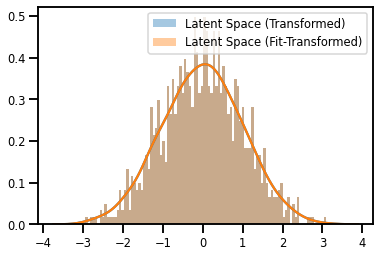

In [25]:
X_g_trans = uni_gaussianize_transform(X_marg, gauss_params)

plt.figure()
sns.distplot(X_g_trans, bins=100, label="Latent Space (Transformed)")
sns.distplot(X_g, bins=100, label="Latent Space (Fit-Transformed)")
plt.legend()
plt.show()

#### JIT

In [26]:
# compile the function to be faster
uni_gaussianization_transform_jitted = jax.jit(uni_gaussianize_transform)

In [27]:
X_g_trans = uni_gaussianization_transform_jitted(X_marg, gauss_params)
%timeit uni_gaussianization_transform_jitted(np.array(X_marg).block_until_ready(), gauss_params)
%timeit uni_gaussianize_transform(np.array(X_marg).block_until_ready(), gauss_params)

400 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
43 ms ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Inverse Transformation

In [28]:
def uniformize_inverse(X: np.ndarray, params: UniParams) -> np.ndarray:
    """Inverse univariate uniformize transformation
    
    Parameters
    ----------
    X : np.ndarray
        The uniform univariate data to be transformed.
    
    params: UniParams
        the tuple containing the params. 
        See `rbig_jax.transforms.histogram` for details.
    
    Returns
    -------
    X_trans : np.ndarray
        The transformed univariate parameters
    """
    return np.interp(X, params.quantiles, params.support)


def uni_gaussianize_inverse(
    X: np.ndarray, 
    params):
    
    # inverse cdf
    X = invgausscdf_inverse_transform(X)
    
    # forward uniformization function
    X = uniformize_inverse(X, params)

    return X

<AxesSubplot:>

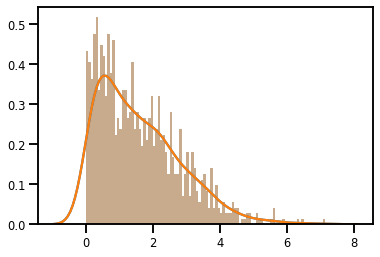

In [29]:
X_approx = uni_gaussianize_inverse(X_g, gauss_params)

sns.distplot(X_approx, bins=100)
sns.distplot(X_marg, bins=100)